## Lab-2: Implement BadNets & Blending Attacks

In [1]:
import os
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset
import torchvision
from torchvision.transforms import Compose, ToTensor, PILToTensor, RandomHorizontalFlip
from BackdoorBox import core

### Global settings

In [2]:
global_seed = 666
deterministic = True
torch.manual_seed(global_seed)
CUDA_VISIBLE_DEVICES = '0'
datasets_root_dir = './datasets'

### Design your pattern

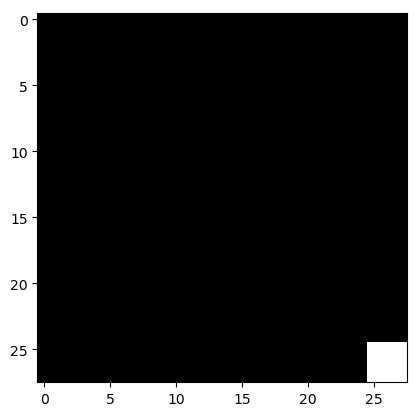

In [3]:
# design your pattern
pattern = torch.zeros((28, 28), dtype=torch.uint8)
pattern[-3:, -3:] = 255
# weight represents the transparency of the pattern when blending with the original image
weight = torch.zeros((28, 28), dtype=torch.float32)
weight[-3:, -3:] = 1.0

# plot the pattern
plt.imshow(pattern, cmap='gray')
plt.show()

### Load the badnet model to create posioned dataset w.r.t. the pattern

In [4]:
import random

dataset = torchvision.datasets.MNIST

transform_train = Compose([
    ToTensor()
])
trainset = dataset(datasets_root_dir, train=True, transform=transform_train, download=True)

transform_test = Compose([
    ToTensor()
])
testset = dataset(datasets_root_dir, train=False, transform=transform_test, download=True)


badnets = core.BadNets(
    train_dataset=trainset,
    test_dataset=testset,
    model=core.models.BaselineMNISTNetwork(),
    loss=nn.CrossEntropyLoss(),
    y_target=1,
    poisoned_rate=0.05,
    pattern=pattern,
    weight=weight,
    seed=global_seed,
    deterministic=deterministic
)


### Look at the poisoned images and their labels

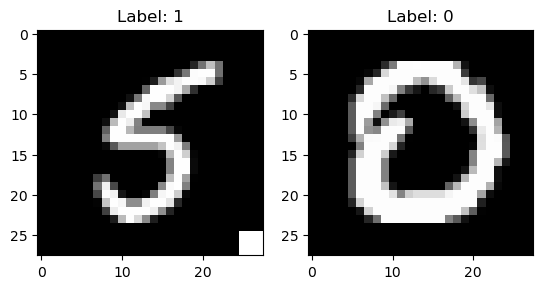

In [5]:
def check_image(attack_model):
    poisoned_train_dataset, poisoned_test_dataset = attack_model.get_poisoned_dataset()

    index_poisoned = random.choice(list(poisoned_train_dataset.poisoned_set))
    index_not_poisoned = random.choice(list(set(range(len(poisoned_train_dataset))) - poisoned_train_dataset.poisoned_set))

    # print('Choose poisoned image\'s index: ', index_poisoned)
    # print('Choose normal image\'s index: ', index_not_poisoned)

    poisoned_img, poisoned_target = poisoned_train_dataset[index_poisoned]
    not_poisoned_img, not_poisoned_target = poisoned_train_dataset[index_not_poisoned]

    fig, ax = plt.subplots(1,2)
    ax[0].imshow(poisoned_img[0], cmap='gray')
    ax[1].imshow(not_poisoned_img[0], cmap='gray')
    ax[0].set_title(f'Label: {poisoned_target}')
    ax[1].set_title(f'Label: {not_poisoned_target}')

check_image(badnets)

### Train a backdoor model using poisoned training dataset

In [6]:
# Train Attacked Model (schedule is set by yamengxi)
schedule = {
    'device': 'GPU',
    'CUDA_VISIBLE_DEVICES': CUDA_VISIBLE_DEVICES,
    'GPU_num': 1,

    'benign_training': False,
    'batch_size': 128,
    'num_workers': 2,

    'lr': 0.1,
    'momentum': 0.9,
    'weight_decay': 5e-4,
    'gamma': 0.1,
    'schedule': [150, 180],

    'epochs': 200,

    'log_iteration_interval': 100,
    'test_epoch_interval': 10,
    'save_epoch_interval': 10,

    'save_dir': 'experiments',
    'experiment_name': 'BaselineMNISTNetwork_MNIST_BadNets'
}
badnets.train(schedule)

This machine has 1 cuda devices, and use 1 of them to train.
Total train samples: 60000
Total test samples: 10000
Batch size: 128
iteration every epoch: 468
Initial learning rate: 0.1

[2023-02-15_18:09:37] Epoch:1/200, iteration:100/468, lr: 0.1, loss: 0.3149707019329071, time: 4.419658422470093

[2023-02-15_18:09:38] Epoch:1/200, iteration:200/468, lr: 0.1, loss: 0.30918779969215393, time: 0.8378949165344238

[2023-02-15_18:09:38] Epoch:1/200, iteration:300/468, lr: 0.1, loss: 0.2900635302066803, time: 0.7798385620117188

[2023-02-15_18:09:39] Epoch:1/200, iteration:400/468, lr: 0.1, loss: 0.07986508309841156, time: 0.870307207107544

[2023-02-15_18:09:40] Epoch:2/200, iteration:31/468, lr: 0.1, loss: 0.10777091234922409, time: 1.035475492477417

[2023-02-15_18:09:41] Epoch:2/200, iteration:131/468, lr: 0.1, loss: 0.11096446216106415, time: 0.7604620456695557

[2023-02-15_18:09:42] Epoch:2/200, iteration:231/468, lr: 0.1, loss: 0.09296438097953796, time: 0.7737858295440674

[2023-02-